In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from collections import defaultdict

use_cuda = torch.cuda.is_available()

In [2]:
from torch_utils import pad_sequence

In [3]:
PAD_TOKEN = 0
BOS_TOKEN = 1
NAN_TOKEN = 2
EOS_TOKEN = 3
SPECIAL_TOKENS = 4
OCCURING_SPECIAL_TOKENS = 1

In [4]:
class DatasetFilesLocation:
    def __init__(self, train, dev, test, tokens):
        self.train = train
        self.dev = dev
        self.test = test
        self.tokens = tokens

In [5]:
src_files = DatasetFilesLocation(
    train='../preprocessed/he-en/src.train.txt',
    dev='../preprocessed/he-en/src.dev.txt',
    test='../preprocessed/he-en/src.test.txt',
    tokens='../preprocessed/he-en/src.tokens.txt')

trg_files = DatasetFilesLocation(
    train='../preprocessed/he-en/tgt.train.txt',
    dev='../preprocessed/he-en/tgt.dev.txt',
    test='../preprocessed/he-en/tgt.test.txt',
    tokens='../preprocessed/he-en/tgt.tokens.txt')

In [135]:
class Lang:
    def __init__(self, tokens_file_path):
        self.idx2word = defaultdict(lambda: "<NAN/>")
        self.word2idx = defaultdict(lambda: NAN_TOKEN)
        with open(tokens_file_path) as tokens_file:
            tokens = tokens_file.readlines()
            for word, idx in map(lambda x: x.strip().split(), tokens):
                idx = int(idx) + SPECIAL_TOKENS
                self.idx2word[idx] = word
                self.word2idx[word] = idx
            assert PAD_TOKEN not in self.idx2word
            assert BOS_TOKEN not in self.idx2word
            assert EOS_TOKEN not in self.idx2word
            for word, idx in [('<PAD/>', PAD_TOKEN), ('<S>', BOS_TOKEN),
                              ('</S>', EOS_TOKEN), ('<NAN/>', NAN_TOKEN)]:
                self.idx2word[idx] = word
                self.word2idx[word] = idx
    
    def convert(self, sentence):
        if isinstance(sentence, str):
            sentence = sentence.strip().split()
        return [BOS_TOKEN] + list(map(lambda word: self.word2idx[word], sentence)) + [EOS_TOKEN]
    
    def input_size(self):
        return len(self.idx2word.keys())
    
    def output_size(self):
        return len(self.idx2word.keys())# - SPECIAL_TOKENS + OCCURING_SPECIAL_TOKENS
    
    def get_word(self, idx):
        return self.idx2word[idx]# + SPECIAL_TOKENS - OCCURING_SPECIAL_TOKENS]
    
    def get_eos(self):
        return EOS_TOKEN #OCCURING_SPECIAL_TOKENS - 1

In [136]:
def form_batch_variable(lang, sentences):
    sentences = list(map(lang.convert, sentences))
    sentences = sorted(sentences, key=len, reverse=True)
    lengths = list(map(len, sentences))
    sentences = list(map(lambda sentence: Variable(torch.LongTensor(sentence)), sentences))
    batch = pad_sequence(sentences, batch_first=True, padding_value=PAD_TOKEN)
    if use_cuda:
        batch = batch.cuda()
    return torch.nn.utils.rnn.pack_padded_sequence(batch, lengths, batch_first=True)

In [137]:
class HyperParameters:
    def __init__(self):
        self.max_length = 100
        self.enc_hidden_size = 128
        self.enc_emb_size = 32
        self.enc_layers = 1
        self.enc_dropout = 0.1
        self.enc_bidirectional = True
        
        self.dec_hidden_size = 128
        self.dec_emb_size = 32
        self.dec_layers = 1
        self.dec_dropout = 0.1
        self.dec_bidirectional = True
        
        self.batch_size = 100
        self.learning_rate = 0.001
        self.clip = 0.25
     
    def get_enc_output_size(self):
        return self.enc_hidden_size * (int(self.enc_bidirectional) + 1)
    
    def get_dec_output_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1)
    
    def get_dec_state_size(self):
        return self.dec_hidden_size * (int(self.dec_bidirectional) + 1) * self.dec_layers

In [138]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hp):
        super(EncoderRNN, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=input_size,
                                      embedding_dim=hp.enc_emb_size,
                                      padding_idx=PAD_TOKEN)
        
        self.gru = nn.GRU(input_size=hp.enc_emb_size,
                          hidden_size=hp.enc_hidden_size,
                          batch_first=True,
                          dropout=hp.enc_dropout,
                          num_layers=hp.enc_layers,
                          bidirectional=hp.enc_bidirectional)
        self.num_directions = (int(hp.enc_bidirectional) + 1)
        self.num_layers = hp.enc_layers
        self.hidden_size = hp.enc_hidden_size

    def forward(self, input_batch, input_lengths, hidden=None):
        """
        """

        if (hidden is None):
            hidden = self.init_hidden(input_batch.size(0))
        embedded = self.embedding(input_batch)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths, batch_first=True)
        outputs, _ = self.gru(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(
            outputs, padding_value=PAD_TOKEN, batch_first=True)
        return outputs, output_lengths

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [139]:
def get_mask(lengths):
    batch_size = lengths.size(0)
    max_len = lengths[0]
    time = torch.arange(max_len).repeat(batch_size, 1)
    lengths = lengths.view(-1, 1).type(torch.FloatTensor)
    if (use_cuda):
        time = time.cuda()
        lengths = lengths.cuda()

    mask = Variable((time < lengths).type(torch.FloatTensor))
    if (use_cuda):
        return mask.cuda()
    return mask

In [140]:
class Attn(nn.Module):
    def __init__(self, hp):
        super(Attn, self).__init__()
        self.attn = nn.Linear(hp.get_enc_output_size() + hp.get_dec_state_size(), 1)

    def forward(self, hidden, encoder_outputs, mask):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers * directions, B, HD)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (B, T, HE)
        :param encoder_output_lengths:
            lengths of encoded sentences, in shape (B,)
        :return
            attention energies in shape (B,T)
        '''
        batch_size = encoder_outputs.size(0)
        max_len = encoder_outputs.size(1)

        hidden = hidden.transpose(0, 1).contiguous() # [B, l * d, HD]
        hidden = hidden.view(batch_size, -1) # [B, HD * layers * directions]
        hidden = hidden.repeat(max_len, 1, 1).transpose(0, 1) # [B, T, HD * layers * directions]
        
        energies = self.attn(torch.cat((hidden, encoder_outputs), -1)).view(batch_size, max_len) # [B, T, 1]

        
        energies = energies * mask
        energies = F.softmax(energies)
        energies = energies * mask
        energies = energies / energies.sum(1).view(-1, 1) # [B, T]
        
        return (energies.view(batch_size, max_len, 1) * encoder_outputs).sum(1) #[B, HE]

In [141]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, output_size, hp):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(input_size, hp.dec_emb_size, padding_idx=PAD_TOKEN)
        self.attn = Attn(hp)
        self.gru = nn.GRU(input_size=hp.dec_emb_size + hp.get_enc_output_size(),
                          hidden_size=hp.dec_hidden_size,
                          num_layers=hp.dec_layers,
                          batch_first=True,
                          dropout=hp.dec_dropout,
                          bidirectional=hp.dec_bidirectional)
        self.out = nn.Linear(hp.get_dec_output_size(), output_size)

        self.num_layers = hp.dec_layers
        self.num_directions = int(hp.dec_bidirectional) + 1
        self.output_size = output_size
        self.hidden_size = hp.dec_hidden_size


    def forward(self, input, encoder_outputs, mask, hidden=None):
        """
            input: [B,]
            encoder_outputs: [B, T, HE]
            hidden: [B, layers * directions, HD]
        """
        batch_size = input.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size)
        embedded = self.embedding(input.view(-1, 1))
        context = self.attn(hidden, encoder_outputs, mask).view(batch_size, 1, -1)
        rnn_input = torch.cat((embedded, context), -1)
    
        output, next_hidden = self.gru(rnn_input, hidden)
        output = self.out(output).view(batch_size, self.output_size)
        output = F.log_softmax(output, -1)
        
        return output, next_hidden

    def init_hidden(self, batch_size):
        result = Variable(torch.zeros(
            self.num_layers * self.num_directions, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [142]:
source_lang = Lang(tokens_file_path=src_files.tokens)
target_lang = Lang(tokens_file_path=trg_files.tokens)

In [143]:
class Seq2Seq(nn.Module):
    def __init__(self, source_lang, target_lang, hp):
        super(Seq2Seq, self).__init__()
        self.source_lang = source_lang
        self.target_lang = target_lang
        self.encoder = EncoderRNN(source_lang.input_size(), hp)
        self.decoder = DecoderRNN(target_lang.input_size(), target_lang.output_size(), hp)
        self.max_length = hp.max_length
        self.criterion = nn.NLLLoss(reduce=False, size_average=False)
        
    def translate(self, input_seq):

        input_batch, input_lengths = torch.nn.utils.rnn.pad_packed_sequence(
            input_seq, batch_first=True, padding_value=PAD_TOKEN)
        encoder_outputs, encoder_output_lengths = self.encoder(input_batch, input_lengths)
        encoder_output_lengths = torch.LongTensor(encoder_output_lengths)
        mask = get_mask(encoder_output_lengths)
        
        batch_size = input_batch.size(0)
        
        dec_input = Variable(torch.LongTensor([BOS_TOKEN] * batch_size))
        if use_cuda:
            dec_input = dec_input.cuda()
        max_length = min(self.max_length, 2 * encoder_output_lengths[0])
        hidden = None
        translations = [[BOS_TOKEN] for _ in range(batch_size)]
        for i in range(max_length):
            output, hidden = self.decoder(dec_input, encoder_outputs, mask=mask, hidden=hidden)
            _, output_idx = torch.max(output, -1)
            for j in range(batch_size):
                if translations[j][-1] != target_lang.get_eos():
                    translations[j].append(output_idx[j].data[0])
            dec_input = Variable(torch.LongTensor([tr[-1] for tr in translations]))
            if use_cuda:
                dec_input = dec_input.cuda()
        return [' '.join(map(target_lang.get_word, elem)) for elem in translations]
    
    def forward(self, input_seq, output_seq):
        input_batch, input_lengths = torch.nn.utils.rnn.pad_packed_sequence(
            input_seq, batch_first=True, padding_value=PAD_TOKEN)
        encoder_outputs, encoder_output_lengths = self.encoder(input_batch, input_lengths)
        encoder_output_lengths = torch.LongTensor(encoder_output_lengths)
        mask = get_mask(encoder_output_lengths)
        batch_size = input_batch.size(0)
        
        if use_cuda:
            dec_input = dec_input.cuda()
        
        hidden = None
        
        logits = []
        output_batch, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(output_seq,
                                                                              batch_first=True,
                                                                              padding_value=PAD_TOKEN)
        output_lengths = torch.LongTensor(output_lengths)
        out_mask = get_mask(output_lengths)
        loss = 0
        outputs = []
        for i in range(len(output_seq) - 1):
            output, hidden = self.decoder(output_batch[:, i], encoder_outputs, mask=mask, hidden=hidden)
            loss += (self.criterion(output, output_batch[:, i + 1]) * out_mask[:, i + 1]).sum()
        
        loss /= out_mask.sum()
        return loss
        

In [144]:
from tqdm import tqdm_notebook
def trainS2S(s2s, src, trg, hp):
    s2s.train()
    losses = []
    hp.batch_size = 100
    assert(len(src) == len(trg))
    optimizer = torch.optim.Adam(s2s.parameters(), lr=hp.learning_rate)
    for i in tqdm_notebook(range(0, len(src), hp.batch_size)):
        src_batch = form_batch_variable(source_lang, src[i : i + hp.batch_size])
        trg_batch = form_batch_variable(target_lang, trg[i : i + hp.batch_size])
        loss = s2s(src_batch, trg_batch)
        if (i // hp.batch_size) % 100 == 0:
            print(loss.data[0])
        losses.append(loss.data[0])
        loss.backward()
        torch.nn.utils.clip_grad_norm(s2s.parameters(), hp.clip)
        optimizer.step()
    return losses
        

In [145]:
hp = HyperParameters()
s2s = Seq2Seq(source_lang, target_lang, hp)
trainS2S(s2s, ["'a 'a d y r", "'a 'a h b ckh"], ["a a d i r", "e a h a v k h a"], hp)

A Jupyter Widget

0.4028926193714142



/home/thefacetakt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0.4028926193714142]

In [146]:
def read_file(filename):
    with open(filename) as file:
        return list(map(str.strip, file.readlines()))

In [147]:
hp = HyperParameters()
s2s = Seq2Seq(source_lang, target_lang, hp)
losses = trainS2S(s2s, read_file(src_files.train)[:30000], read_file(trg_files.train)[:30000], hp)

A Jupyter Widget

/home/thefacetakt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.41578713059425354
0.29900214076042175
3.941352133551845e-06



In [148]:
from matplotlib import pyplot as plt
%matplotlib inline

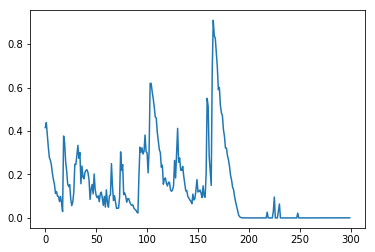

In [149]:
plt.plot(losses)

In [150]:
s2s.eval()

Seq2Seq(
  (encoder): EncoderRNN(
    (embedding): Embedding(90, 32, padding_idx=0)
    (gru): GRU(32, 128, batch_first=True, dropout=0.1, bidirectional=True)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(32, 32, padding_idx=0)
    (attn): Attn(
      (attn): Linear(in_features=512, out_features=1)
    )
    (gru): GRU(288, 128, batch_first=True, dropout=0.1, bidirectional=True)
    (out): Linear(in_features=256, out_features=32)
  )
  (criterion): NLLLoss(
  )
)

In [151]:
s2s.translate(form_batch_variable(source_lang, ["'a 'a d y r", "'a 'a h b ckh"]))

/home/thefacetakt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['<S> b b b b b b b b b b b b b b', '<S> b b b b b b b b b b b b b b']